# Test setup for Mask RCNN trained on floating objects data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

%tensorflow_version 1.x

import tensorflow
print(tensorflow.__version__)

!pip install h5py==2.10.0
!pip install q keras==2.1.0

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

%cd Mask_RCNN
!pwd
!python3 setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 33.92 MiB/s, done.
Resolving deltas: 100% (565/565), done.
/content/Mask_RCNN
/content/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, undersc

In [ ]:
import os
import sys
import imagesize
import numpy as np
import math
from matplotlib import image

from mrcnn.config import Config
from mrcnn import model as modellib, utils

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT_DIR = os.path.abspath("./")
print(ROOT_DIR)

DRIVE_ROOT_DIR = "/content/drive/My Drive/mrcnn"

DEFAULT_LOGS_DIR = os.path.join(DRIVE_ROOT_DIR, "logs")
print(DEFAULT_LOGS_DIR)

# COCO_WEIGHTS_PATH = os.path.join(DRIVE_ROOT_DIR, "mask_rcnn_coco.h5")
# print(COCO_WEIGHTS_PATH)

LAST_WEIGHTS_PATH = os.path.join(DRIVE_ROOT_DIR, "mask_rcnn_floatingobjects_0200.h5")
print(LAST_WEIGHTS_PATH)

DATASET_DIR = os.path.join(DRIVE_ROOT_DIR, "dataset")
print(DATASET_DIR)

sys.path.append(ROOT_DIR)

/content/Mask_RCNN
/content/drive/My Drive/mrcnn/logs
/content/drive/My Drive/mrcnn/mask_rcnn_floatingobjects_0200.h5
/content/drive/My Drive/mrcnn/dataset


In [ ]:
class SimpleConfig(Config):
  NAME = "inference"
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  NUM_CLASSES = 1 + 1
  
class FloatingObjectsDataset(utils.Dataset):
    """
    Load a subset of Floating Objects dataset.
    dataset_dir: Root directory of the dataset.
    subset: Subset to load: train/validation/test
    """
    def load_objects(self, dataset_dir, subset):
        self.add_class("person", 1, "person")

        assert subset in ["train", "validation", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        """
        YOLO: In YOLO labeling format, a .txt file with the
        same name is created for each image file in the same
        directory. Each .txt contains he annotations for the
        corresponding image file, that is object class, object
        coordinates, height and width.
        <object-class> <x> <y> <width> <height>
        """
        annotations = {}
        for annotation_filename in os.listdir(dataset_dir):
            if annotation_filename.endswith(".txt"):
                annotation_file_path = f"{dataset_dir}/{annotation_filename}"
                raw_filename = os.path.splitext(annotation_filename)[0]
                with open(annotation_file_path, 'rb') as f:
                    elements = []
                    raw_data = f.read().splitlines()
                    for line in raw_data:
                        line = line.decode("utf-8")
                        single_annotaton = line.split(' ')
                        # Remove bounding boxes for non-persons
                        if (single_annotaton[0] != '0'):
                            continue
                        elements.append(single_annotaton)
                        if (len(elements) == 0):
                            continue
                    annotations[raw_filename] = elements

        # Load images
        images = {}
        for image_filename in os.listdir(dataset_dir):
            if image_filename.endswith(".jpg"):
                raw_filename = os.path.splitext(image_filename)[0]
                if len(annotations[raw_filename]) == 0:
                    continue
                image_file_path = f"{dataset_dir}/{image_filename}"
                width, height = imagesize.get(image_file_path)
                images[raw_filename] = {}
                images[raw_filename]['path'] = image_file_path
                images[raw_filename]['width'] = width
                images[raw_filename]['height'] = height
                images[raw_filename]['annotations'] = annotations[raw_filename]


        for key in images:
            self.add_image(
                "person",
                image_id=key,
                path=images[key]['path'],
                width=images[key]['width'],
                height=images[key]['height'],
                annotations=images[key]['annotations'])


    def yolo_to_box(self, yolo_annotation: list, img_width, img_height):
        """
        Trasform bounding boxes in YOLO 
        format to standard bounding boxes
        """
        x = float(yolo_annotation[1])
        y = float(yolo_annotation[2])
        width = float(yolo_annotation[3])
        height = float(yolo_annotation[4])

        x_min, y_min = int((x-width/2)* img_width), int((y-height/2)*img_height)
        x_max, y_max = int((x+width/2) * img_width), int((y+height/2)*img_height)

        return [x_min, y_min, x_max, y_max]

    def load_mask(self, image_id):
        """
        Generate instance mask for an image
        """
        info = self.image_info[image_id]

        # Transform bounding boxes in YOLO
        # format to standard bounding boxes
        boxes = []
        for element in info['annotations']:
            box = self.yolo_to_box(element, info['width'], info['height'])
            boxes.append(box)

        # Create one array for all masks, each on different channel
        masks = np.zeros([info['height'], info['width'], len(boxes)], dtype='uint8')

        # Create masks
        for index in range(len(boxes)):
            box = boxes[index]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, index] = 1

        return masks.astype(np.bool), np.ones([masks.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """
        Return the path of the image.
        """
        info = self.image_info[image_id]
        return info['path']

In [ ]:
dataset_train = FloatingObjectsDataset()
dataset_train.load_objects(DATASET_DIR, "train")
dataset_train.prepare()
print("Train image count: {}".format(len(dataset_train.image_ids)))
print("Train class count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
  print("{:3}. {:50}".format(i, info['name']))

Train image count: 1532
Train class count: 2
  0. BG                                                
  1. person                                            


In [ ]:
dataset_validation = FloatingObjectsDataset()
dataset_validation.load_objects(DATASET_DIR, "validation")
dataset_validation.prepare()

print("Validation image count: {}".format(len(dataset_validation.image_ids)))
print("Validation class count: {}".format(dataset_validation.num_classes))
for i, info in enumerate(dataset_validation.class_info):
  print("{:3}. {:50}".format(i, info['name']))

Validation image count: 214
Validation class count: 2
  0. BG                                                
  1. person                                            


In [ ]:
dataset_test = FloatingObjectsDataset()
dataset_test.load_objects(DATASET_DIR, "test")
dataset_test.prepare()

print("Test image count: {}".format(len(dataset_test.image_ids)))
print("Test class count: {}".format(dataset_test.num_classes))
for i, info in enumerate(dataset_test.class_info):
  print("{:3}. {:50}".format(i, info['name']))

Test image count: 361
Test class count: 2
  0. BG                                                
  1. person                                            


In [ ]:
# https://github.com/matterport/Mask_RCNN/issues/2513

from mrcnn import utils
from sklearn import metrics

def compute_ar(pred_boxes, gt_boxes, list_iou_thresholds):
# pred_boxes: Are the coordinates of the expected bounding box;
# gt_boxes: Are the coordinates of the actual bounding box;
# list_iou_thresholds: List of thresholds that will be used.
  AR = []
  for iou_threshold in list_iou_thresholds:

      try:
          recall, _ = utils.compute_recall(pred_boxes, gt_boxes, iou=iou_threshold)

          AR.append(recall)

      except:
        AR.append(0.0)
        pass

  AUC = 2 * (metrics.auc(list_iou_thresholds, AR))
  return AUC

  

In [ ]:
from mrcnn import utils
from statistics import mean
# from modellib import load_image_gt, mold_image, expand_dims, compute_ap, compute_ar
from mrcnn import model as modellib

def evaluate_model(dataset, model, cfg, list_iou_thresholds=None):
  """
  dataset - an object of a class that inherits from the Dataset class in utils.py
  model - an object resulting from the MaskRCNN class available in the module model.py
  cfg - an object of a class that inherits the super class config.py
  """
  if list_iou_thresholds is None: list_iou_tresholds = np.arange(0.5, 1.01, 0.1)

  APs = [] # average precision
  ARs = [] # average recall

  for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

    r = model.detect([image])
    r = r[0]

    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                                   r["rois"], r["class_ids"], r["scores"], 
                                                   r['masks'], iou_threshold=0.5)
    
    AR = compute_ar(r['rois'], gt_bbox, list_iou_thresholds)
    print(AP)
    
    APs.append(AP)
    ARs.append(AR)

  mAP = mean(APs)
  mAR = mean(ARs)
  return mAP, mAR

model = modellib.MaskRCNN(
                          mode="inference",
                          config=SimpleConfig(),
                          model_dir=DEFAULT_LOGS_DIR
                          )

weights_path = LAST_WEIGHTS_PATH
model.load_weights(weights_path, by_name=True)

print("Loading weights ", weights_path)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Loading weights  /content/drive/My Drive/mrcnn/mask_rcnn_floatingobjects_0100_4czer.h5


In [ ]:
mAP, mAR = evaluate_model(dataset_test, model, SimpleConfig(), np.arange(0.5, 1.01, 0.1))

print("Test set mAP: ", mAP)
print("Test set mAR: ", mAR)

KeyboardInterrupt: ignored

image ID: person.cv_1250 (211) /content/drive/My Drive/mrcnn/dataset/test/cv_1250.jpg


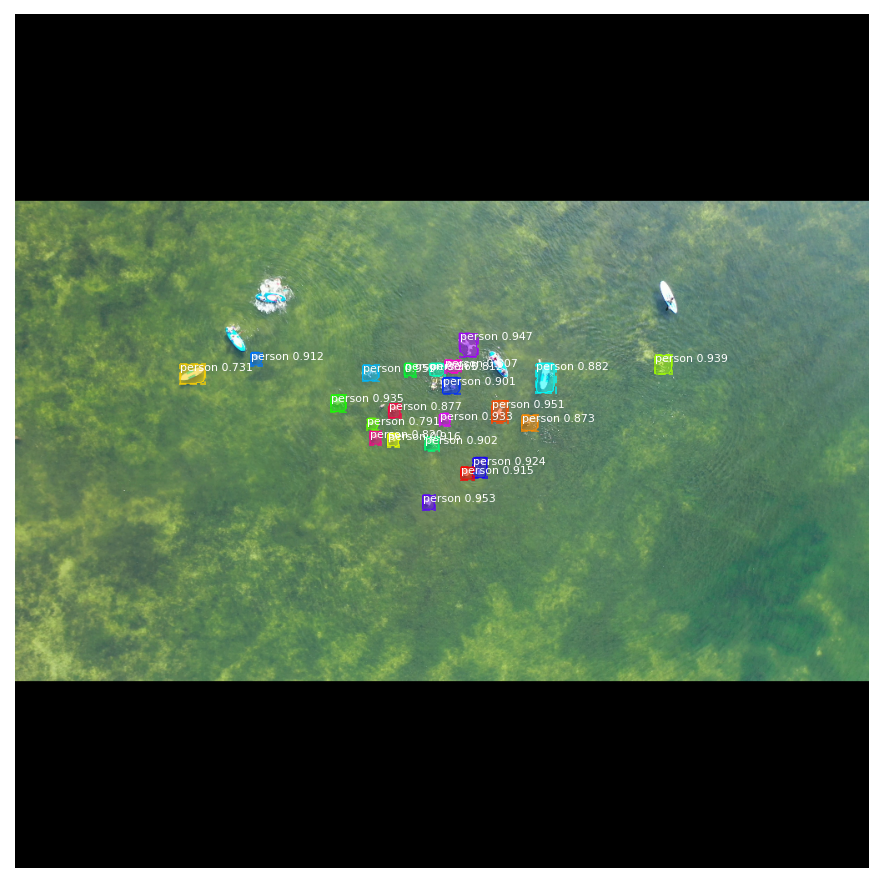

In [ ]:
# https://blog.paperspace.com/object-detection-directed-mask-r-cnn-keras/
import random
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os

PHOTO_PATH = DRIVE_ROOT_DIR + "/dataset/test/a_389.jpg"
# PHOTO_PATH = DRIVE_ROOT_DIR + "/dataset/Fig07.jpg"
CLASS_NAMES = ["BG", "person"]

# print("Loading test set...")
# dataset_test = FloatingObjectsDataset()
# dataset_test.load_objects(DATASET_DIR, "test")
# dataset_test.prepare()
# print("Test set loaded.")

model = mrcnn.model.MaskRCNN(mode="inference",
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# model.load_weights(filepath=COCO_WEIGHTS_PATH,
#                    by_name=True,exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

model.load_weights(weights_path, by_name=True)

# https://github.com/matterport/Mask_RCNN/issues/363

# image=cv2.imread(PHOTO_PATH)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_id = random.choice(dataset_test.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, SimpleConfig(), image_id, use_mini_mask=False)
info = dataset_test.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_test.image_reference(image_id)))



r = model.detect([image])

r = r[0]

mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])